# UC-8 Artifact Re-evaluate

Phase26.3 notebook with executed diagnostics outputs.

## Overview
- Purpose: Artifact re-evaluation quick reference.
- API: `evaluate(artifact, new_data)`
- Outputs: reeval_compare.csv, precheck.csv, re-eval diagnostics

## Learn More
Detailed tutorial: `notebooks/tutorials/tutorial_01_regression_basics.ipynb`

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_lift_chart,
    plot_love_plot,
    plot_nll_histogram,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_true_class_prob_histogram,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase26_2_uc08_artifact_reevaluate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-8'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config Notes
- Keep compatibility output directories under `examples/out/phase26_*`.
- Keep key tuning knobs annotated with inline comments when modifying config payloads.

## Workflow

### Output Annotation
The following workflow cells materialize plots/tables consumed by evidence tests.

,ok,missing_columns,required_columns
ok_case,True,[],"[x1, x2]"
missing_case,False,[x2],"[x1, x2]"


,metric,train_value,reeval_value,delta
0,rmse,0.932623,0.435733,-0.496890
1,mae,0.719654,0.287226,-0.432429
2,r2,0.897713,0.977044,0.079332


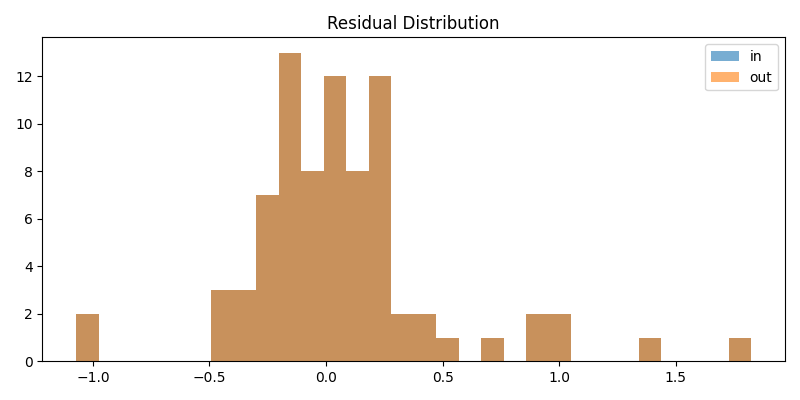

In [2]:
def _cb_result_eval_precheck(schema_payload: dict[str, object], frame: pd.DataFrame) -> dict[str, object]:
    required = [str(c) for c in schema_payload.get('feature_names', [])]
    missing = [col for col in required if col not in frame.columns]
    return {'ok': len(missing) == 0, 'missing_columns': missing, 'required_columns': required}

marker = ROOT / 'examples' / 'out' / 'phase26_2_uc01_regression_fit_evaluate' / 'latest_artifact_path.txt'
if marker.exists():
    artifact_path = Path(marker.read_text(encoding='utf-8').strip())
else:
    candidates = sorted((ROOT / 'examples' / 'out' / 'phase26_2_uc01_regression_fit_evaluate' / 'artifacts').glob('*'))
    if not candidates:
        raise FileNotFoundError('No UC-1 artifact found for reevaluate.')
    artifact_path = candidates[-1]

artifact = Artifact.load(artifact_path)
reeval_df = pd.read_csv(ROOT / 'examples' / 'out' / 'phase26_2_uc08_artifact_reevaluate' / 'reeval_ok.csv')
missing_df = pd.read_csv(ROOT / 'examples' / 'out' / 'phase26_2_uc08_artifact_reevaluate' / 'reeval_missing_col.csv')

schema_payload = {'feature_names': artifact.feature_schema.get('feature_names', [])}
precheck_ok = _cb_result_eval_precheck(schema_payload, reeval_df)
precheck_bad = _cb_result_eval_precheck(schema_payload, missing_df)

reeval = evaluate(artifact, reeval_df)
y_true = reeval_df['target'].to_numpy(dtype=float)
y_pred = np.asarray(artifact.predict(reeval_df.drop(columns=['target'])), dtype=float)
residual = y_true - y_pred

train_metrics = artifact.metrics.get('mean', {}) if isinstance(artifact.metrics, dict) else {}
rows = []
for metric in ['rmse', 'mae', 'mape', 'r2']:
    if metric in reeval.metrics:
        train_value = train_metrics.get(metric)
        reeval_value = float(reeval.metrics[metric])
        rows.append(
            {
                'metric': metric,
                'train_value': None if train_value is None else float(train_value),
                'reeval_value': reeval_value,
                'delta': None if train_value is None else reeval_value - float(train_value),
            }
        )

compare_df = pd.DataFrame(rows)
compare_path = OUT_DIR / 'reeval_compare.csv'
compare_df.to_csv(compare_path, index=False)
precheck_path = OUT_DIR / 'precheck.csv'
pd.DataFrame([precheck_ok, precheck_bad], index=['ok_case', 'missing_case']).to_csv(precheck_path)

hist_path = diag_dir / 'reeval_hist.png'
plot_error_histogram(residual, residual, reeval.metrics, reeval.metrics, hist_path)

metrics_df = compare_df.rename(columns={'metric': 'label'})
if metrics_df.empty:
    metrics_df = pd.DataFrame([{'label': 'reeval', **reeval.metrics}])

display(pd.DataFrame([precheck_ok, precheck_bad], index=['ok_case', 'missing_case']))
display(compare_df)
display(Image(filename=str(hist_path)))

summary_outputs = [compare_path, precheck_path, hist_path]
artifact_path_for_summary = artifact_path


## Result Summary

In [3]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-8',
 'executed_at_utc': '2026-02-17T14:05:46.164390+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase26_2_uc01_regression_fit_evaluate/artifacts/85ca91c87c304cfa9aad2a884983bb47',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase26_2_uc08_artifact_reevaluate/reeval_compare.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc08_artifact_reevaluate/precheck.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc08_artifact_reevaluate/diagnostics/reeval_hist.png'],
 'metrics': [{'label': 'rmse',
   'train_value': 0.932623,
   'reeval_value': 0.435733,
   'delta': -0.49689},
  {'label': 'mae',
   'train_value': 0.719654,
   'reeval_value': 0.287226,
   'delta': -0.432429},
  {'label': 'r2',
   'train_value': 0.897713,
   'reeval_value': 0.977044,
   'delta': 0.079332}]}